# [Bag of Words Meets Bags of Popcorn | Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-3-more-fun-with-word-vectors)

# 튜토리얼 파트 3, 4
* [DeepLearningMovies/KaggleWord2VecUtility.py at master · wendykan/DeepLearningMovies](https://github.com/wendykan/DeepLearningMovies/blob/master/KaggleWord2VecUtility.py)
* 캐글에 링크되어 있는 github 튜토리얼을 참고하여 만들었으며 파이썬2로 되어있는 소스를 파이썬3에 맞게 일부 수정하였다.

## 첫 번째 시도(average feature vectors)
* 튜토리얼2의 코드로 벡터의 평균을 구한다.

## 두 번째 시도(K-means)
* Word2Vec은 의미가 관련있는 단어들의 클러스터를 생성하기 때문에 클러스터 내의 단어 유사성을 이용하는 것이다.
* 이런식으로 벡터를 그룹화 하는 것을 "vector quantization(벡터 양자화)"라고 한다.
* 이를 위해서는 K-means와 같은 클러스터링 알고리즘을 사용하여 클러스터라는 단어의 중심을 찾아야 한다.
* 비지도학습인 K-means를 통해 클러스터링을 하고 지도 학습인 랜덤포레스트로 리뷰가 추천인지 아닌지를 예측한다.

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\dhcho\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
model = Word2Vec.load('300features_40minwords_10text')
model

In [4]:
# 숫자로 단어를 표현
# Word2Vec 모델은 어휘의 각 단어에 대한 feature 벡터로 구성되며
# 'syn0'이라는 넘파이 배열로 저장된다.
# syn0의 행 수는 모델 어휘의 단어 수
# 컬럼 수는 2 부에서 설정한 피처 벡터의 크기
# syn0은 없어진다네..vectors를 쓰래..
#type(model.wv.syn0)
type(model.wv.vectors)

numpy.ndarray

In [5]:
model.wv.vectors

array([[-0.03234428, -0.00671174, -0.05238718, ..., -0.03021022,
        -0.09220278,  0.00401431],
       [ 0.07275347, -0.01586343,  0.00909527, ..., -0.11436571,
        -0.01074888,  0.12905693],
       [-0.06465231,  0.0129442 , -0.05703328, ..., -0.09814436,
        -0.04150106, -0.07486822],
       ...,
       [-0.10614059,  0.01756263,  0.09682815, ...,  0.09859474,
        -0.05539701, -0.04712197],
       [-0.00181569, -0.00548203,  0.02253792, ...,  0.05794495,
        -0.04915455, -0.00330533],
       [ 0.00751472,  0.07652881, -0.1302071 , ...,  0.07351982,
        -0.04508839,  0.00936924]], dtype=float32)

In [6]:
len(model.wv.vectors)

11986

In [7]:
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
model.wv.vectors.shape

(11986, 300)

In [8]:
# 개별 단어 벡터 접근
model.wv['flower'].shape

(300,)

In [9]:
model.wv['flower'][:10]

array([ 0.06319489, -0.02579345,  0.10246982, -0.20173304,  0.0132709 ,
        0.02720401, -0.01936636, -0.03557153,  0.04559345,  0.02022864],
      dtype=float32)

## K-means (K평균) 클러스터링으로 데이터 묶기
* [K-평균 알고리즘 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)
* 클러스터링은 비지도 학습 기법
* 클러스터링은 유사성 등 개념에 기초해 몇몇 그룹으로 분류하는 기법
* 클러스터링의 목적은 샘플(실수로 구성된 n차원의 벡터)을 내부적으로는 비슷하지만 외부적으로 공통 분모가 없는 여러 그룹으로 묶는 것
* 특정 차원의 범위가 다른 차원과 차이가 크면 클러스터링 하기 전에 스케일을 조정해야 한다.

    1. 최초 센트로이드(centroid)(중심점)로 k개의 벡터를 무작위로 선정한다.
    2. 각 샘플을 그 위치에서 가장 가까운 센트로이드에 할당한다.
    3. 센트로이드의 위치를 재계산한다.
    4. 센트로이드가 더 이상 움직이지 않을 때까지 2와 3을 반복한다.

참고 : [책]모두의 데이터 과학(with 파이썬)

In [10]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5 이나 평균 5단어로 설정한다.
word_vectors = model.wv.vectors # model.wv.syn0 어휘의 feature vector
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)

# K means를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난 시간에서 시작 시간을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering : ", elapsed, "seconds.")

C:\Users\dhcho\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Time taken for K Means clustering :  345.56650018692017 seconds.


In [30]:
print("{} / {} = {}".format(word_vectors.shape[0], 5, num_clusters))

11986 / 5 = 2397


In [13]:
model.wv.index2word

['the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'this',
 'that',
 's',
 'movi',
 'film',
 'was',
 'as',
 'with',
 'for',
 'but',
 'you',
 't',
 'be',
 'on',
 'have',
 'not',
 'he',
 'are',
 'his',
 'one',
 'all',
 'at',
 'they',
 'like',
 'by',
 'who',
 'an',
 'from',
 'so',
 'there',
 'her',
 'or',
 'just',
 'about',
 'out',
 'has',
 'if',
 'what',
 'time',
 'some',
 'make',
 'good',
 'can',
 'charact',
 'more',
 'when',
 'see',
 'get',
 'veri',
 'she',
 'up',
 'watch',
 'stori',
 'no',
 'even',
 'would',
 'my',
 'which',
 'their',
 'onli',
 'realli',
 'had',
 'well',
 'scene',
 'do',
 'other',
 'were',
 'we',
 'me',
 'bad',
 'look',
 'than',
 'most',
 'much',
 'end',
 'show',
 'will',
 'great',
 'go',
 'peopl',
 'been',
 'also',
 'into',
 'first',
 'love',
 'becaus',
 'him',
 'how',
 'way',
 'don',
 'play',
 'think',
 'act',
 'thing',
 'them',
 'made',
 'then',
 'could',
 'too',
 'after',
 'seem',
 'ani',
 'know',
 'say',
 'plot',
 'work',
 'two',
 'actor',
 'year',
 

In [15]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫번째 클러스터의 처음 10개를 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))
    
    # 클러스터번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['instinct']

Cluster 1
['amsterdam', 'pittsburgh', 'tel']

Cluster 2
['harri', 'pete', 'boon', 'clayton', 'shane', 'axel', 'lam', 'callahan', 'bradford', 'hanson', 'blacki', 'richi', 'trent', 'muller', 'bannist', 'manuel', 'igor', 'dong', 'paolo', 'foreman', 'hartnett', 'carney', 'eliot', 'quigley']

Cluster 3
['peni', 'crotch', 'genit']

Cluster 4
['cement', 'pinch', 'fountain', 'holder']

Cluster 5
['feminist', 'pregnanc', 'infidel', 'promiscu', 'delinqu', 'shenanigan', 'puritan', 'misogyni', 'femin', 'puberti', 'chauvinist', 'pubesc']

Cluster 6
['usag', 'hobbit', 'rotoscop']

Cluster 7
['eraserhead', 'detractor', 'jodorowski', 'blasphem']

Cluster 8
['jeremi', 'thespian', 'mcgregor', 'northam', 'ewan', 'gackt', 'frasier']

Cluster 9
['ambigu', 'chao', 'decept', 'manifest', 'fractur', 'permeat', 'uncertainti', 'reconcili', 'anarchi', 'strife']


In [16]:
list(word_centroid_map.values())[0]

2043

In [25]:
max( word_centroid_map.values() ) + 1

2397

In [24]:
len(word_centroid_map)

11986

In [17]:
"""
Pandas로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1),
QUOTE_NONUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와
clean_test_reviews 로 텍스트를 정제한다.
"""
train = pd.read_csv('./data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('./data/testData.tsv', header=0, delimiter='\t', quoting=3)
# unlabeled_train = pd.read_csv('./data/unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

In [26]:
train.shape

(25000, 3)

In [27]:
test.shape

(25000, 2)

In [18]:
from KaggleWord2VecUtility import KaggleWord2VecUtility
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist(review,\
                                remove_stopwords=True))

In [19]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist(review,\
                                remove_stopwords=True))

In [21]:
# bag of centroids 생성
# 속도를 위해 centroid 학습 셋트 bag을 미리 할당 한다.
train_centroids = np.zeros((train["review"].size, num_clusters),\
                          dtype="float32")
train_centroids[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
train_centroids.shape

(25000, 2397)

In [23]:
# centroid 는 두 클러스터의 중심점을 정의한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids(wordlist, word_centroid_map):
    # 클러스터의 수는 word_centroid map 에서 가장 높은 클러스트 인덱스와 같다
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당되는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [31]:
# 학습 리뷰를 bags of centroids 로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
                                    word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
                                     dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
                                    word_centroid_map )
    counter += 1

# 랜덤 포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators=100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time 을 통해 걸린 시간을 찍도록 함.
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

Fitting a random forest to labeled training data...
Wall time: 46.8 s


In [32]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
                    forest, train_centroids, train["sentiment"], cv=10, \
                    scoring='roc_auc'))

Wall time: 7min 13s


In [33]:
%time result = forest.predict(test_centroids)

Wall time: 1.72 s


In [34]:
score

0.9162025920000001

In [35]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("./data/submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

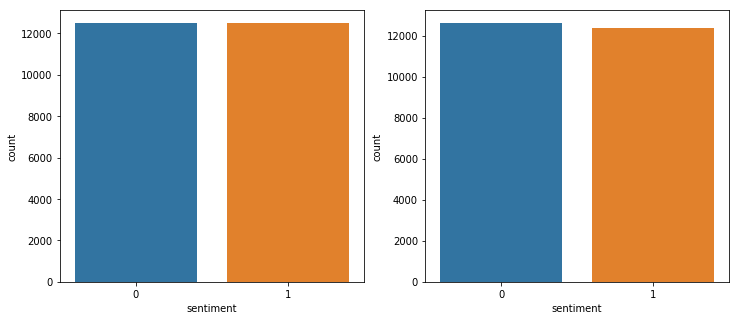

In [36]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [37]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

246


0    12623
1    12377
Name: sentiment, dtype: int64

In [40]:
# 캐글 점수 
print(515/578)

0.8910034602076125


# 왜 이 튜토리얼에서는 Bag of Words가 더 좋은 결과를 가져올까?
벡터를 평균화하고 centroids를 사용하면 단어 순서가 어긋나며 Bag of Words 개념과 매우 비슷하다. 성능이 (표준 오차의 범위 내에서) 비슷하기 때문에 튜토리얼 1, 2, 3이 동등한 결과를 가져온다.

첫째, Word2Vec을 더 많은 텍스트로 학습시키면 성능이 좋아진다. Google의 결과는 10억 단어가 넘는 코퍼스에서 배운 단어 벡터를 기반으로 한다. 학습 레이블이 있거나 레이블이 없는 학습 세트는 단지 대략 천팔백만 단어 정도다. 편의상 Word2Vec은 Google의 원래 C도구에서 출력되는 사전 학습된 모델을 로드하는 기능을 제공하기 때문에 C로 모델을 학습한 다음 Python으로 가져올 수도 있다.

둘째, 출판된 자료들에서 분산 워드 벡터 기술은 Bag of Words 모델보다 우수한 것으로 나타났다. 이 논문에서는 IMDB 데이터 집합에 단락 벡터 (Paragraph Vector)라는 알고리즘을 사용하여 현재까지의 최첨단 결과 중 일부를 생성한다. 단락 벡터는 단어 순서 정보를 보존하는 반면 벡터 평균화 및 클러스터링은 단어 순서를 잃어 버리기 때문에 여기에서 시도하는 방식보다 부분적으로 더 좋다.
* 더 공부하기 : 스탠포트 NLP 강의 : [Lecture 1 | Natural Language Processing with Deep Learning - YouTube](https://www.youtube.com/watch?v=OQQ-W_63UgQ&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6)